<a href="https://colab.research.google.com/github/cwscx/makmore/blob/main/makemore_part5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
words: list[str] = open('names.txt', 'r').read().splitlines()

In [4]:
stoi: dict[str, int] = {c:i for i, c in enumerate('.abcdefghijklmnopqrstuvwxyz')}
itos: dict[int, str] = {i:c for c, i in stoi.items()}
vocab_size = len(stoi)

In [5]:
import random
random.seed(42)
random.shuffle(words)

In [56]:
block_size = 8

def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
  inputs_list: list[list[int]] = []
  labels_list: list[int] = []

  for w in words:
    inputs: list[int] = [0] * block_size
    for c in w + '.':
      index: int = stoi[c]
      inputs_list.append(inputs)
      labels_list.append(index)
      inputs = inputs[1:] + [index]

  return torch.tensor(inputs_list), torch.tensor(labels_list)

threshold1: int = int(0.8 * len(words))
threshold2: int = int(0.9 * len(words))

training_x, training_y = build_dataset(words[:threshold1])
validation_x, validation_y = build_dataset(words[threshold1:threshold2])
test_x, test_y = build_dataset(words[threshold2:])

In [142]:
from math import nan

class Linear:

  def __init__(self, fan_in: int, fan_out: int, bias: bool=True) -> None:
    self.weight: torch.Tensor = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
    self.bias: torch.Tensor | None = torch.zeros(fan_out) if bias else None

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    self.out: torch.Tensor = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim: int, eps: float=1e-5, momentum: float=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters.
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    if (self.training):
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)

      x_mean = x.mean(dim, keepdim=True)
      x_var = x.var(dim, keepdim=True, unbiased=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    standardized_x = (x - x_mean) / torch.sqrt(x_var - self.eps)
    self.out = self.gamma * standardized_x + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    self.out = torch.tanh(x)
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return []

class Embedding:

  def __init__(self, num_embedding, embedding_dim) -> None:
    self.weight = torch.randn((num_embedding, embedding_dim))

  def __call__(self, IX) -> torch.Tensor:
    self.out = self.weight[IX]
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return [self.weight]

class FlattenConsecutive:

  def __init__(self, n: int) -> None:
    self.n = n

  def __call__(self, x) -> torch.Tensor:
    # [a,b,c] => [a,b/2,c*2]
    # return torch.concat([x[:, ::2, :], x[:, 1::2, :]], dim=2)
    B, L, C = x.shape # B(atch), L(ength of context/sequence), C(hannel)
    x = x.view(B, L // self.n, C * self.n)
    if x.shape[1] == 1:
      # x = x.view(B, -1)
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return []

class Sequential:

  def __init__(self, layers) -> None:
    self.layers = layers

  def __call__(self, x):
    output = x
    for layer in self.layers:
      output = layer(output)

    return output

  def parameters(self) -> list[torch.Tensor]:
    return [p for layer in self.layers for p in layer.parameters()]

In [116]:
torch.manual_seed(42)

In [206]:
n_embed = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

76579


In [207]:
ix = torch.randint(0, training_x.shape[0], (4,))
x_batch = training_x[ix]
y_batch = training_y[ix]
logits = model(x_batch)
print(x_batch.shape, ix.shape)
x_batch

torch.Size([4, 8]) torch.Size([4])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0, 10, 21, 19, 20,  5, 14],
        [ 0,  0,  0,  0, 11,  5, 12, 12],
        [ 0,  0,  0,  0,  0,  0,  0, 14]])

In [208]:
for layer in model.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [209]:
max_steps = 50000
batch_size = 32
losses = []

for i in range(max_steps):
  # Minibatch construct.
  indexes = torch.randint(0, training_x.shape[0], (batch_size, ))
  batch_x = training_x[indexes]
  batch_y = training_y[indexes]

  # Forward pass.
  logits = model(batch_x)
  loss = F.cross_entropy(logits, batch_y)

  # Backward pass.
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < max_steps * 0.75 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

  # break

      0/  50000: 3.3000
  10000/  50000: 2.1818
  20000/  50000: 2.0569
  30000/  50000: 2.1737
  40000/  50000: 2.0727


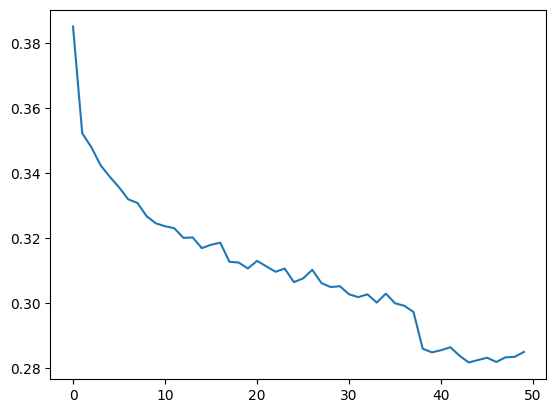

In [210]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [211]:
for layer in model.layers:
  layer.training = False

In [212]:
@torch.no_grad()
def split_loss(split: str):
  x, y = {
      'train': (training_x, training_y),
      'val': (validation_x, validation_y),
      'test': (test_x, test_y),
  }[split]

  logits = model(x)
  # print(logits)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.9061310291290283
val 2.0053839683532715
test 2.0002455711364746


In [213]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mesli.
leviata.
liney.
selaijah.
emik.
tailine.
dayyin.
karryn.
hendree.
omavie.
brenny.
sanvie.
lamyah.
chenico.
sedrakin.
unniver.
ediandra.
xia.
eddan.
conne.


In [81]:
a = torch.tensor([[[1,2,3],[4,5,6],[7,8,9],[10,11,12]]])
print(a.shape)
print(a[:, ::2, :].shape)
print(torch.concat([a[:, ::2, :], a[:, 1::2, :]], dim=2))

torch.Size([1, 4, 3])
torch.Size([1, 2, 3])
tensor([[[ 1,  2,  3,  4,  5,  6],
         [ 7,  8,  9, 10, 11, 12]]])
